## Machine Learning Challenge – Using AI to Validate Carbon Containment in the Illinois Basin 
### Date: Apr 2023

Problem Statement

This challenge aims to use time series injection information and monitoring data on a carbon capture well to predict carbon capture well injection rates deltas. Correlating the change in injection rate to the behavior of other parameters in the well can be used to provide a checkpoint against carbon migration from the well or other losses during the process. The code developed to predict injection rate deltas based on monitoring well data can be used to validate carbon containment throughout the injection of the well.

In [1]:
#!pip install hampel
#https://www.kaggle.com/code/nouramedhat/air-pollution-lstm

In [2]:
#!pip install mplcursors

In [3]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import mplcursors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pathlib import Path
import os.path


import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler

from hampel import hampel

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

import math
from sklearn.metrics import mean_squared_error

In [4]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [5]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real')
    plt.plot(predicted, color='blue',label='Predicted')
    plt.title('Prediction')
    plt.xlabel('Time')
    plt.ylabel('Inj_Delta')
    plt.legend()
    plt.show()

### Load Cleaned Data

In [6]:
#set directory for csv files
dir_name = r'C:\Users\vasan\OneDrive - California Resources Corporation\01_Admin\07_MLChallenge'
filename_suffix = 'csv'

In [7]:
#read file
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_csv("Cleaned_data2.csv", thousands=',', skiprows = skiprows, index_col='SampleTimeUTC',parse_dates=['SampleTimeUTC'])
df.head()

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_VW1_WBTbgPs_psi,Avg_VW1_ANPs_psi,Avg_VW1_Z01D7061Ps_psi,inj_diff
SampleTimeUTC,,,,,,,,
2009-10-01 00:00:00,20.543221,700.605639,149.097828,3005.665373,2173.710958,1599.975952,3216.464494,0.0
2009-10-01 01:00:00,20.543221,700.605639,149.097828,3005.665373,2173.762679,1599.975952,3216.520127,0.0
2009-10-01 02:00:00,20.543221,700.605639,149.097828,3005.665373,2173.754085,1599.975952,3216.510374,0.0
2009-10-01 03:00:00,20.543221,700.605639,149.097828,3005.665373,2173.734355,1599.975952,3216.479380,0.0
2009-10-01 04:00:00,20.543221,700.605639,149.097828,3005.665373,2173.738489,1599.975952,3216.436283,0.0


C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


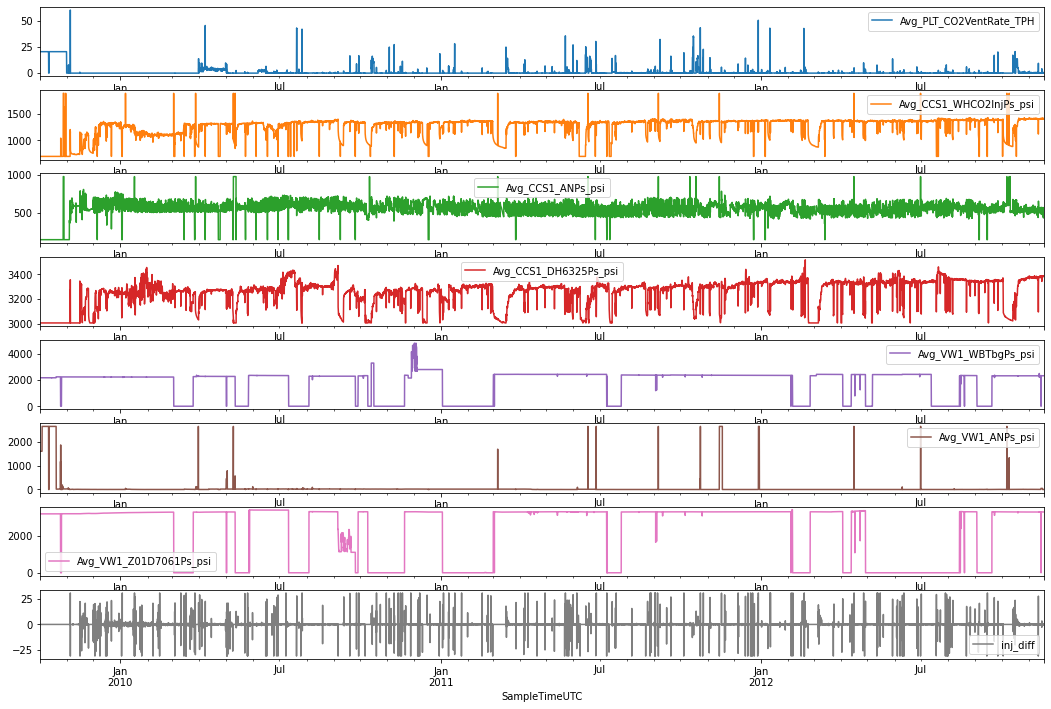

In [8]:
# Create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 12))
df.plot(ax=ax, subplots=True)
plt.show()

In [9]:
#read file
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df_blind = pd.read_csv("illinois_basing_test_04112023.csv", thousands=',', skiprows = skiprows, index_col='SampleTimeUTC',parse_dates=['SampleTimeUTC'])
df_blind.head()
df_blind["inj_diff"] = 0

In [10]:
#df_blind['SampleTimeUTC'] = pd.to_datetime(df_blind['SampleTimeUTC'])
#df_blind = df_blind.set_index("SampleTimeUTC")
idx = pd.date_range(df_blind.index[0], df_blind.index[-1])

#df1 = df1.reindex(idx, fill_value=np.nan).dropna()
df_blind.index.name = "SampleTimeUTC"

df_blind = df_blind.asfreq('H')

#df1.index.freq = "H"
#df_blind

In [11]:
df_blind_new = df_blind[['Avg_PLT_CO2VentRate_TPH',
                         'Avg_CCS1_WHCO2InjPs_psi',
                         'Avg_CCS1_ANPs_psi',
                         'Avg_CCS1_DH6325Ps_psi',
                         'Avg_VW1_WBTbgPs_psi',
                         'Avg_VW1_Z01D7061Ps_psi',
                         'inj_diff',
                        ]]

data2 = df_blind_new.copy()
data2

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_VW1_WBTbgPs_psi,Avg_VW1_Z01D7061Ps_psi,inj_diff
SampleTimeUTC,,,,,,,
2012-11-18 08:00:00,0.825000,1406.469561,522.013451,3383.554036,2329.030835,3320.276693,0
2012-11-18 09:00:00,0.641667,1406.399989,510.494516,3385.778632,2329.015361,3320.269031,0
2012-11-18 10:00:00,0.633333,1406.588710,510.899432,3383.531185,2329.055794,3320.298985,0
2012-11-18 11:00:00,0.633333,1407.000806,511.896438,3384.563845,2329.133431,3320.306563,0
2012-11-18 12:00:00,0.458333,1406.682945,510.982277,3385.062998,2329.147909,3320.344305,0
...,...,...,...,...,...,...,...
2012-11-26 12:00:00,1.708333,1418.840352,440.463678,3398.568276,2327.606797,3321.700452,0
2012-11-26 13:00:00,1.708333,1418.537537,432.052225,3399.234914,2327.799504,3321.754409,0
2012-11-26 14:00:00,1.716667,1418.984295,513.740069,3400.701626,2327.909432,3321.721102,0


In [12]:
df

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_VW1_WBTbgPs_psi,Avg_VW1_ANPs_psi,Avg_VW1_Z01D7061Ps_psi,inj_diff
SampleTimeUTC,,,,,,,,
2009-10-01 00:00:00,20.543221,700.605639,149.097828,3005.665373,2173.710958,1599.975952,3216.464494,0.000000
2009-10-01 01:00:00,20.543221,700.605639,149.097828,3005.665373,2173.762679,1599.975952,3216.520127,0.000000
2009-10-01 02:00:00,20.543221,700.605639,149.097828,3005.665373,2173.754085,1599.975952,3216.510374,0.000000
2009-10-01 03:00:00,20.543221,700.605639,149.097828,3005.665373,2173.734355,1599.975952,3216.479380,0.000000
2009-10-01 04:00:00,20.543221,700.605639,149.097828,3005.665373,2173.738489,1599.975952,3216.436283,0.000000
...,...,...,...,...,...,...,...,...
2012-11-18 03:00:00,0.408333,1409.701282,530.799145,3385.511261,2328.919804,0.100585,3320.264079,-0.031250
2012-11-18 04:00:00,0.458333,1409.036129,531.937228,3387.451438,2328.912415,0.100585,3320.271702,-0.091320
2012-11-18 05:00:00,0.508333,1408.648841,526.400194,3387.077108,2328.921606,0.100585,3320.266923,-0.137501


In [13]:
# concatenate dataframes on datetime index
df2 = pd.concat([df, data2], axis=0)

# print merged dataframe
df2

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_VW1_WBTbgPs_psi,Avg_VW1_ANPs_psi,Avg_VW1_Z01D7061Ps_psi,inj_diff
SampleTimeUTC,,,,,,,,
2009-10-01 00:00:00,20.543221,700.605639,149.097828,3005.665373,2173.710958,1599.975952,3216.464494,0.0
2009-10-01 01:00:00,20.543221,700.605639,149.097828,3005.665373,2173.762679,1599.975952,3216.520127,0.0
2009-10-01 02:00:00,20.543221,700.605639,149.097828,3005.665373,2173.754085,1599.975952,3216.510374,0.0
2009-10-01 03:00:00,20.543221,700.605639,149.097828,3005.665373,2173.734355,1599.975952,3216.479380,0.0
2009-10-01 04:00:00,20.543221,700.605639,149.097828,3005.665373,2173.738489,1599.975952,3216.436283,0.0
...,...,...,...,...,...,...,...,...
2012-11-26 12:00:00,1.708333,1418.840352,440.463678,3398.568276,2327.606797,NaN,3321.700452,0.0
2012-11-26 13:00:00,1.708333,1418.537537,432.052225,3399.234914,2327.799504,NaN,3321.754409,0.0
2012-11-26 14:00:00,1.716667,1418.984295,513.740069,3400.701626,2327.909432,NaN,3321.721102,0.0


C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


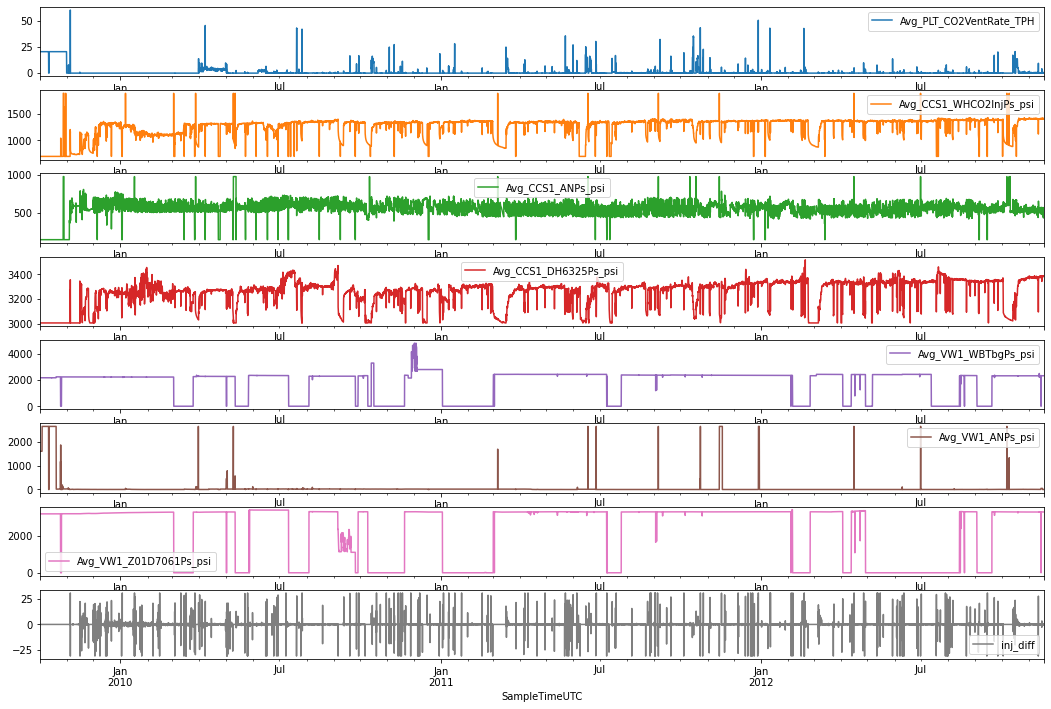

In [14]:
# Create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 12))
df.plot(ax=ax, subplots=True)
plt.show()

### STart here

In [15]:
# Sklearn Liraries
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error , mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

#Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM,Activation

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.layers import Dense,LSTM,Activation, Dropout, Bidirectional, TimeDistributed

# Nueral Networks are stocastic; setting random seeds ensures we get the same output each time
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(tf.__version__)

2.11.0


In [16]:
# normalization to ensure data is on same scale
scaler = MinMaxScaler(feature_range=(-1, 1))

def reshape_data(train_x, train_y, test_x, test_y):
    # convert to [rows, columns] structure
    x_train = train_x.reshape((train_x.shape[0], train_x.shape[1]))
    y_train = train_y.reshape((train_y.shape[0], 1))
    
    x_test = test_x.reshape((test_x.shape[0], test_x.shape[1]))
    y_test = test_y.reshape((test_y.shape[0], 1))

    # normalization features
    x_scaled = scaler.fit_transform(x_train)
    testx_scaled = scaler.transform(x_test)
    
    y_scaled = scaler.fit_transform(y_train)
    testy_scaled = scaler.transform(y_test)
    
    # horizontally stack columns
    dataset_stacked_train = np.hstack((x_scaled, y_scaled))
    dataset_stacked_test = np.hstack((testx_scaled, testy_scaled))
    
    print ("train dataset_stacked.shape" , dataset_stacked_train.shape) 
    print ("test dataset_stacked.shape" , dataset_stacked_test.shape)
    return dataset_stacked_train, dataset_stacked_test

In [17]:
# split sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out=1):
    
    """
    create lagged value sequence for time series data
    
    Parameters:
    ============
    
    Sequence:
    =========
    The dataset contain x and y values. x can be single column or mutliple columns. Y will be last column.
    
    n_steps_in:
    ===========
    The preferrable window size for past data (or lagged values). 
    
    n_steps_out:
    ============
    The default is 1.
    
    output:
    =======
    x: The independent variable array
    y: The y(dependent variable)
    
    """
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [18]:
#loss plot to identify optimal model parameters from training
def loss_plot(history):
    
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model accuracy')
    plt.ylabel('Mean Square Error')
    plt.xlabel('epoch')
    plt.legend(['train MSE', 'val MSE'], loc='upper left')
    plt.show()
    
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'val loss'], loc='upper left')
    plt.show()

In [19]:
# To evaluate how well model predictions are doing
def evaluate_prediction(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    r2 = r2_score(actual, predictions)
    print('Mean Square Error: {:.2f}'.format(mse))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('R-Square: {:.2f}'.format(r2))
    print('')
    print('')
    
    list_df = [mse, rmse, mae, r2]
    df = pd.DataFrame(list_df, index=["MSE", "RMSE", "MAE", "R^2"])
    
    return df

In [20]:
# To Note:
# 1. n-neurons: Using 50 neurons, which can increased or decreased to check if it affects model results.
# 2. lr = Learning rate: Very important parameter; smaller values decrease model overfitting but increase computation time
# 3. optimizer = Adam: Note that we have to use the .legacy as new version of tf has some conflict
# 4. Dropout: By dropping out the nodes (input and hidden layer) in a neural network, all the forward and backwards
#    connections with a dropped node are temporarily removed, thus creating a new network architecture out of the 
#    parent network. The nodes are dropped by a dropout probability of p. It is applied to reduce overfitting
# 5. Stacked LSTM: An LSTM layer provides a sequence output rather than a single value output to the LSTM layer. 
#    Specifically, one output per input time step (creating a 3D data set), rather than one output time step for all 
#    input time steps (i.e. 1 single value)

# The selected model is a 2 layer STACKED LSTM. This can also be increased by adding a new LSTM layer

def LSTM_model(opt, n_steps_in, n_features, n_steps_out, neurons, dropout, activation):
    
    """
    Parameters:
    ============
    
    opt:
    ====
    The learning rate for the model. default is 0.1
    
    n_steps_in:
    ===========
    The window size for past data(or lagged values), called samples.
    
    n_features:
    ============
    How many independent variables are used. 

    n_steps_out:
    =============
    The output size, which is 1 in this case
    
    output:
    =======
    compiled model
    
    """
    # define model
    model = Sequential()
    
    # add LSTM layer with tanh activation. return_sequences=True is used so we can feed another 
    # LSTM layer to model. default is false.
    model.add(LSTM(neurons, activation=activation, return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(Dropout(dropout))
    # second layer of LSTM with tanh activation. Now return sequence is False, as there will be no other layer
    # except output layer.
    model.add(LSTM(neurons, activation=activation))
    model.add(Dropout(dropout))
    
    # final layer with output
    model.add(Dense(n_steps_out))
    
    # activation function of output layer
    model.add(Activation('tanh'))
    
    # compile model with loss funtion, optimizer and metrics
    model.compile(loss='mse' , optimizer=opt , metrics=['mse'])
    
    return model

In [21]:
data = df.copy()
data.index

DatetimeIndex(['2009-10-01 00:00:00', '2009-10-01 01:00:00',
               '2009-10-01 02:00:00', '2009-10-01 03:00:00',
               '2009-10-01 04:00:00', '2009-10-01 05:00:00',
               '2009-10-01 06:00:00', '2009-10-01 07:00:00',
               '2009-10-01 08:00:00', '2009-10-01 09:00:00',
               ...
               '2012-11-17 22:00:00', '2012-11-17 23:00:00',
               '2012-11-18 00:00:00', '2012-11-18 01:00:00',
               '2012-11-18 02:00:00', '2012-11-18 03:00:00',
               '2012-11-18 04:00:00', '2012-11-18 05:00:00',
               '2012-11-18 06:00:00', '2012-11-18 07:00:00'],
              dtype='datetime64[ns]', name='SampleTimeUTC', length=27464, freq=None)

In [22]:
data

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_VW1_WBTbgPs_psi,Avg_VW1_ANPs_psi,Avg_VW1_Z01D7061Ps_psi,inj_diff
SampleTimeUTC,,,,,,,,
2009-10-01 00:00:00,20.543221,700.605639,149.097828,3005.665373,2173.710958,1599.975952,3216.464494,0.000000
2009-10-01 01:00:00,20.543221,700.605639,149.097828,3005.665373,2173.762679,1599.975952,3216.520127,0.000000
2009-10-01 02:00:00,20.543221,700.605639,149.097828,3005.665373,2173.754085,1599.975952,3216.510374,0.000000
2009-10-01 03:00:00,20.543221,700.605639,149.097828,3005.665373,2173.734355,1599.975952,3216.479380,0.000000
2009-10-01 04:00:00,20.543221,700.605639,149.097828,3005.665373,2173.738489,1599.975952,3216.436283,0.000000
...,...,...,...,...,...,...,...,...
2012-11-18 03:00:00,0.408333,1409.701282,530.799145,3385.511261,2328.919804,0.100585,3320.264079,-0.031250
2012-11-18 04:00:00,0.458333,1409.036129,531.937228,3387.451438,2328.912415,0.100585,3320.271702,-0.091320
2012-11-18 05:00:00,0.508333,1408.648841,526.400194,3387.077108,2328.921606,0.100585,3320.266923,-0.137501


In [23]:
# Create numpy array for further analysis
# choose a number of time steps - change this accordingly
n_steps_in = 50 # Smaller the value, more accurate, slower. Tested 30, 50, 100, with 100 being the worst, and 30 as best
n_steps_out = 1

train = data[:("2011")]
test = data[("2012"):]

x_train, y_train = train.drop("inj_diff", axis=1).values, train["inj_diff"].values
x_test, y_test = test.drop("inj_diff", axis=1).values, test["inj_diff"].values

train_data, test_data = reshape_data(x_train, y_train, x_test, y_test)

# covert into input/output
X, y = split_sequences(train_data, n_steps_in, n_steps_out)
x_test, y_test = split_sequences(test_data, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)

n_features = X.shape[2]

train dataset_stacked.shape (19728, 8)
test dataset_stacked.shape (7736, 8)
X.shape (19679, 50, 7)
y.shape (19679, 1)


In [24]:
n_steps_in = 30
lr = 0.001
epochs = 500
neurons = 50
dropout = 0.2
activation = 'tanh'

opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

train = data[:("2012")]
test = data[("2012"):]

x_train, y_train = train.drop("inj_diff", axis=1).values, train["inj_diff"].values
x_test, y_test = test.drop("inj_diff", axis=1).values, test["inj_diff"].values

train_data, test_data = reshape_data(x_train, y_train, x_test, y_test)

# covert into input/output
X, y = split_sequences(train_data, n_steps_in, n_steps_out)
x_test, y_test = split_sequences(test_data, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)

n_features = X.shape[2]

# caclulate steps based on legth of data and window size
steps_per_epoch = len(X)//n_steps_in
model = LSTM_model(opt, n_steps_in, n_features, n_steps_out, neurons, dropout, activation)
History =  model.fit(X, y, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    verbose=1 , validation_split=0.2, shuffle=False,
                        callbacks=[EarlyStopping('val_loss', mode='min', patience=20)])

train dataset_stacked.shape (27464, 8)
test dataset_stacked.shape (7736, 8)
X.shape (27435, 30, 7)
y.shape (27435, 1)
Epoch 1/500
914/914 [==============================] - 22s 19ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 2/500
914/914 [==============================] - 21s 23ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 3/500
914/914 [==============================] - 23s 25ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 4/500
914/914 [==============================] - 21s 23ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 5/500
914/914 [==============================] - 21s 23ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 6/500
914/914 [==============================] - 21s 23ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/500
914/914 [==============================] - 21s 23ms/step - l

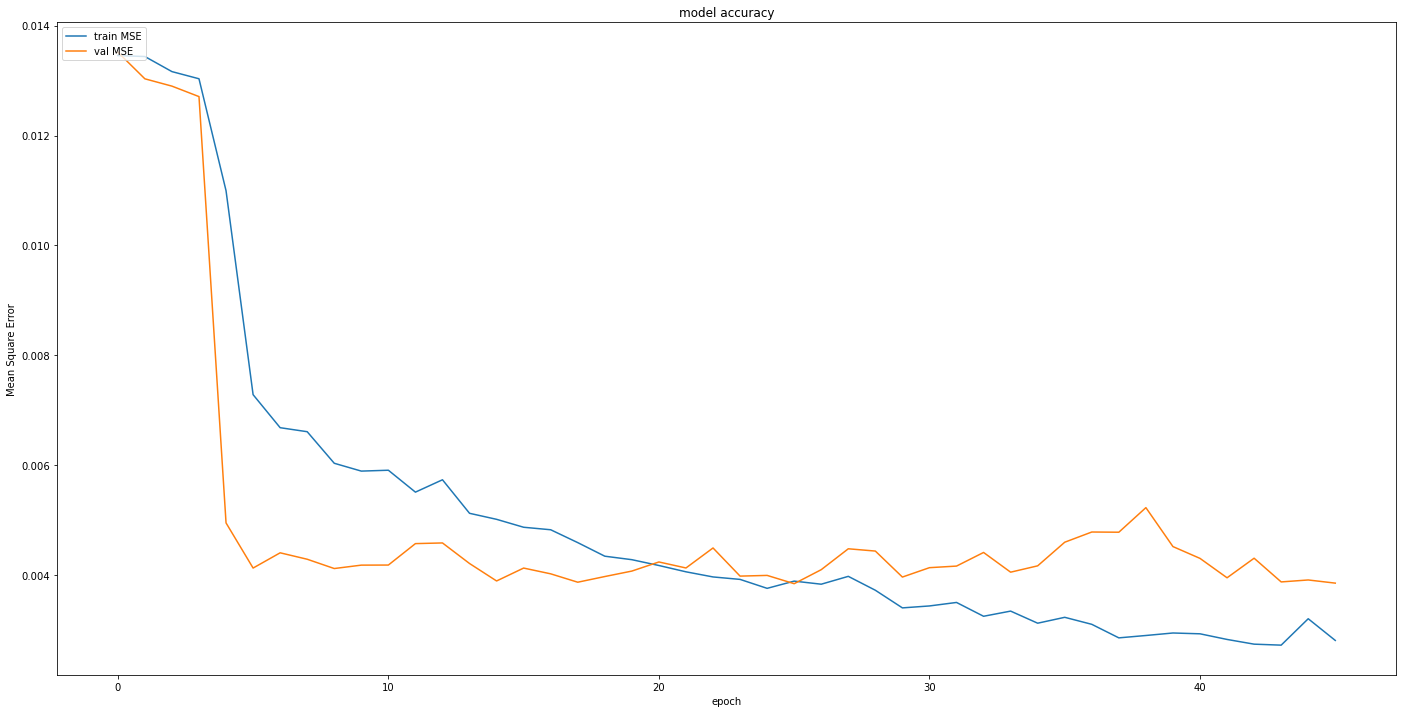

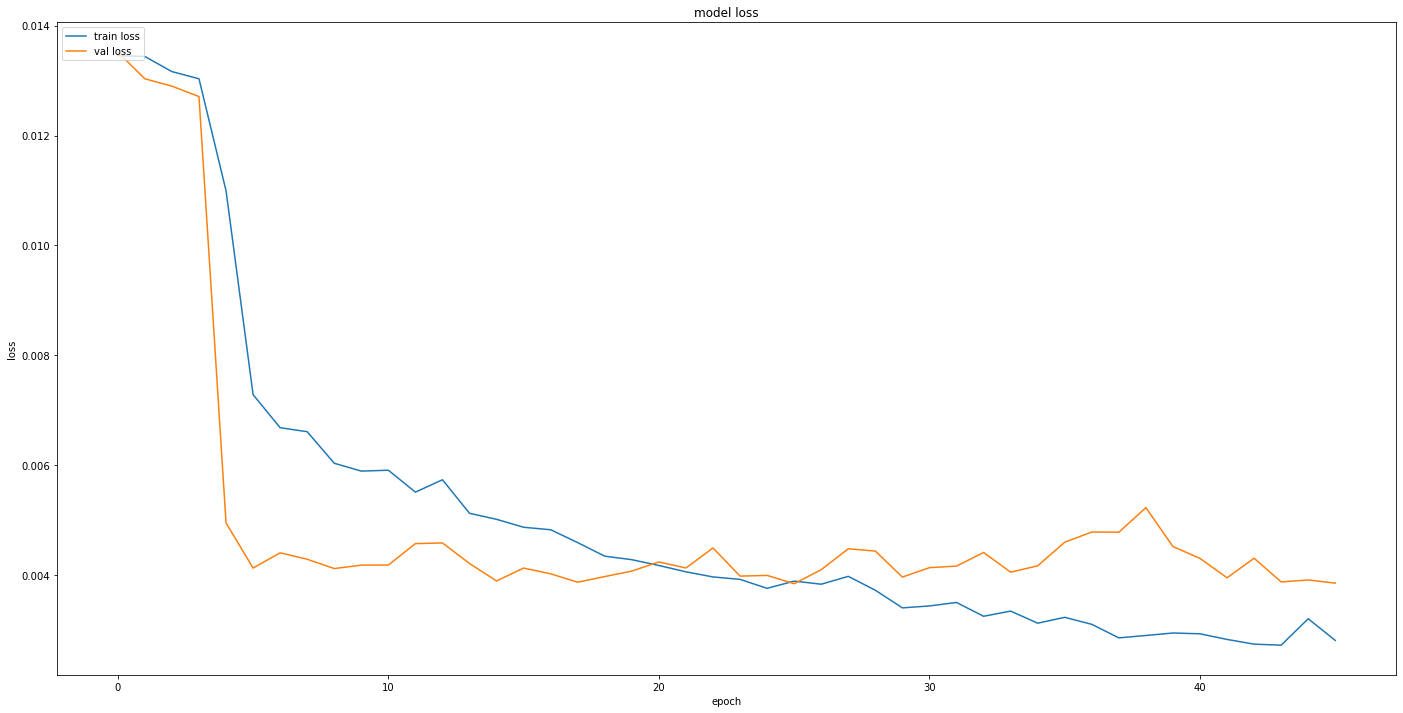

In [25]:
# plot Mean absolute error
loss_plot(History)

241/241 [==============================] - 2s 6ms/step
Mean Square Error: 3.07
Mean Absolute Error: 0.43
Root Mean Square Error: 1.75
R-Square: 0.72




<AxesSubplot:xlabel='SampleTimeUTC'>

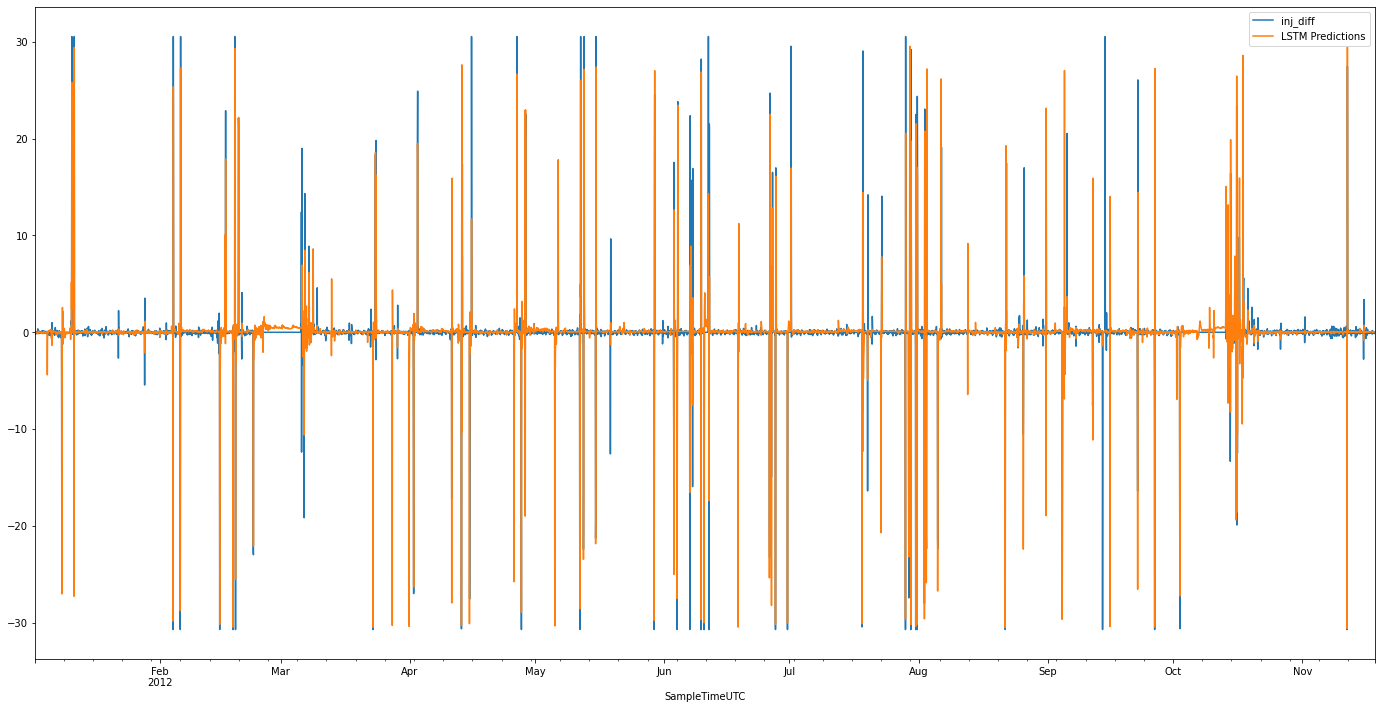

In [26]:
# make predictions and transform
test_pred = scaler.inverse_transform(model.predict(x_test))

pred_test = test[(n_steps_in-1):].copy()
pred_test["LSTM Predictions"] = test_pred
pred_test = pred_test[["inj_diff", "LSTM Predictions"]]

# evaluate predictions accuracy
evaluate_prediction(pred_test["LSTM Predictions"], pred_test["inj_diff"])

pred_test.plot()

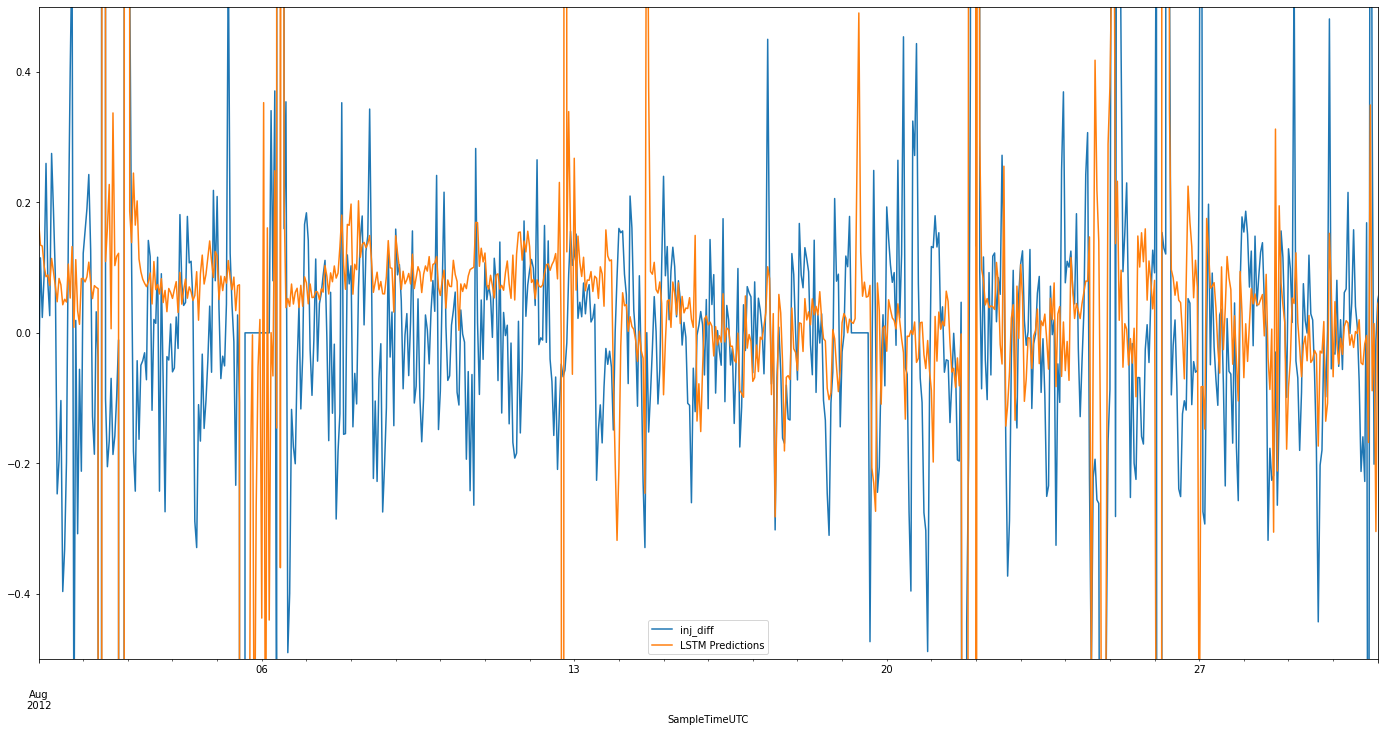

In [27]:
pred_test.plot()
# Set the y-axis limit
plt.ylim([-0.5, 0.5])
plt.xlim(['2012-08-01', '2012-08-31'])

# Display the plot
plt.show()

In [28]:
pred_test

,inj_diff,LSTM Predictions
SampleTimeUTC,,
2012-01-02 05:00:00,-0.082985,0.012446
2012-01-02 06:00:00,0.017317,0.038575
2012-01-02 07:00:00,-0.199262,-0.024221
2012-01-02 08:00:00,-0.119444,0.002025
2012-01-02 09:00:00,-0.073265,-0.005010
...,...,...
2012-11-18 03:00:00,-0.031250,0.036294
2012-11-18 04:00:00,-0.091320,0.045834
2012-11-18 05:00:00,-0.137501,0.040448


# BLIND 

In [29]:
data2 = df2.copy()
data2.index

DatetimeIndex(['2009-10-01 00:00:00', '2009-10-01 01:00:00',
               '2009-10-01 02:00:00', '2009-10-01 03:00:00',
               '2009-10-01 04:00:00', '2009-10-01 05:00:00',
               '2009-10-01 06:00:00', '2009-10-01 07:00:00',
               '2009-10-01 08:00:00', '2009-10-01 09:00:00',
               ...
               '2012-11-26 07:00:00', '2012-11-26 08:00:00',
               '2012-11-26 09:00:00', '2012-11-26 10:00:00',
               '2012-11-26 11:00:00', '2012-11-26 12:00:00',
               '2012-11-26 13:00:00', '2012-11-26 14:00:00',
               '2012-11-26 15:00:00', '2012-11-26 16:00:00'],
              dtype='datetime64[ns]', name='SampleTimeUTC', length=27665, freq=None)

In [30]:
data2 = data2.drop('Avg_VW1_ANPs_psi', axis=1)

In [31]:
nan_count = np.sum(np.isnan(data2))
print(f"There are {nan_count} NaN values in data2.")

There are Avg_PLT_CO2VentRate_TPH    0
Avg_CCS1_WHCO2InjPs_psi    0
Avg_CCS1_ANPs_psi          0
Avg_CCS1_DH6325Ps_psi      0
Avg_VW1_WBTbgPs_psi        0
Avg_VW1_Z01D7061Ps_psi     0
inj_diff                   0
dtype: int64 NaN values in data2.


In [32]:
train2 = data2[:-231]
test2 = data2[-231:]

In [33]:
nan_count = np.sum(np.isnan(train2))
print(f"There are {nan_count} NaN values in data2.")

There are Avg_PLT_CO2VentRate_TPH    0
Avg_CCS1_WHCO2InjPs_psi    0
Avg_CCS1_ANPs_psi          0
Avg_CCS1_DH6325Ps_psi      0
Avg_VW1_WBTbgPs_psi        0
Avg_VW1_Z01D7061Ps_psi     0
inj_diff                   0
dtype: int64 NaN values in data2.


In [34]:
nan_count = np.sum(np.isnan(test2))
print(f"There are {nan_count} NaN values in data2.")

There are Avg_PLT_CO2VentRate_TPH    0
Avg_CCS1_WHCO2InjPs_psi    0
Avg_CCS1_ANPs_psi          0
Avg_CCS1_DH6325Ps_psi      0
Avg_VW1_WBTbgPs_psi        0
Avg_VW1_Z01D7061Ps_psi     0
inj_diff                   0
dtype: int64 NaN values in data2.


In [35]:
n_steps_in = 30
lr = 0.001
epochs = 500
neurons = 50
dropout = 0.2
activation = 'tanh'

opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

x_train, y_train = train2.drop("inj_diff", axis=1).values, train2["inj_diff"].values
x_test, y_test = test2.drop("inj_diff", axis=1).values, test2["inj_diff"].values

train_data, test_data = reshape_data(x_train, y_train, x_test, y_test)

# covert into input/output
X, y = split_sequences(train_data, n_steps_in, n_steps_out)
x_test, y_test = split_sequences(test_data, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)

n_features = X.shape[2]


train dataset_stacked.shape (27434, 7)
test dataset_stacked.shape (231, 7)
X.shape (27405, 30, 6)
y.shape (27405, 1)


In [36]:
nan_count = np.sum(np.isnan(x_test))
print(f"There are {nan_count} NaN values in data2.")

There are 0 NaN values in data2.


In [37]:
nan_count = np.sum(np.isnan(x_train))
print(f"There are {nan_count} NaN values in data2.")

There are 0 NaN values in data2.


In [38]:

# caclulate steps based on legth of data and window size
steps_per_epoch = len(X)//n_steps_in
model = LSTM_model(opt, n_steps_in, n_features, n_steps_out, neurons, dropout, activation)
History =  model.fit(X, y, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    verbose=1 , validation_split=0.2, shuffle=False,
                        callbacks=[EarlyStopping('val_loss', mode='min', patience=20)])

Epoch 1/500
913/913 [==============================] - 21s 18ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 2/500
913/913 [==============================] - 16s 17ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 3/500
913/913 [==============================] - 18s 20ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 4/500
913/913 [==============================] - 20s 22ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 5/500
913/913 [==============================] - 20s 22ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 6/500
913/913 [==============================] - 20s 22ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 7/500
913/913 [==============================] - 20s 22ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 8/500
913/913 [==============================] - 

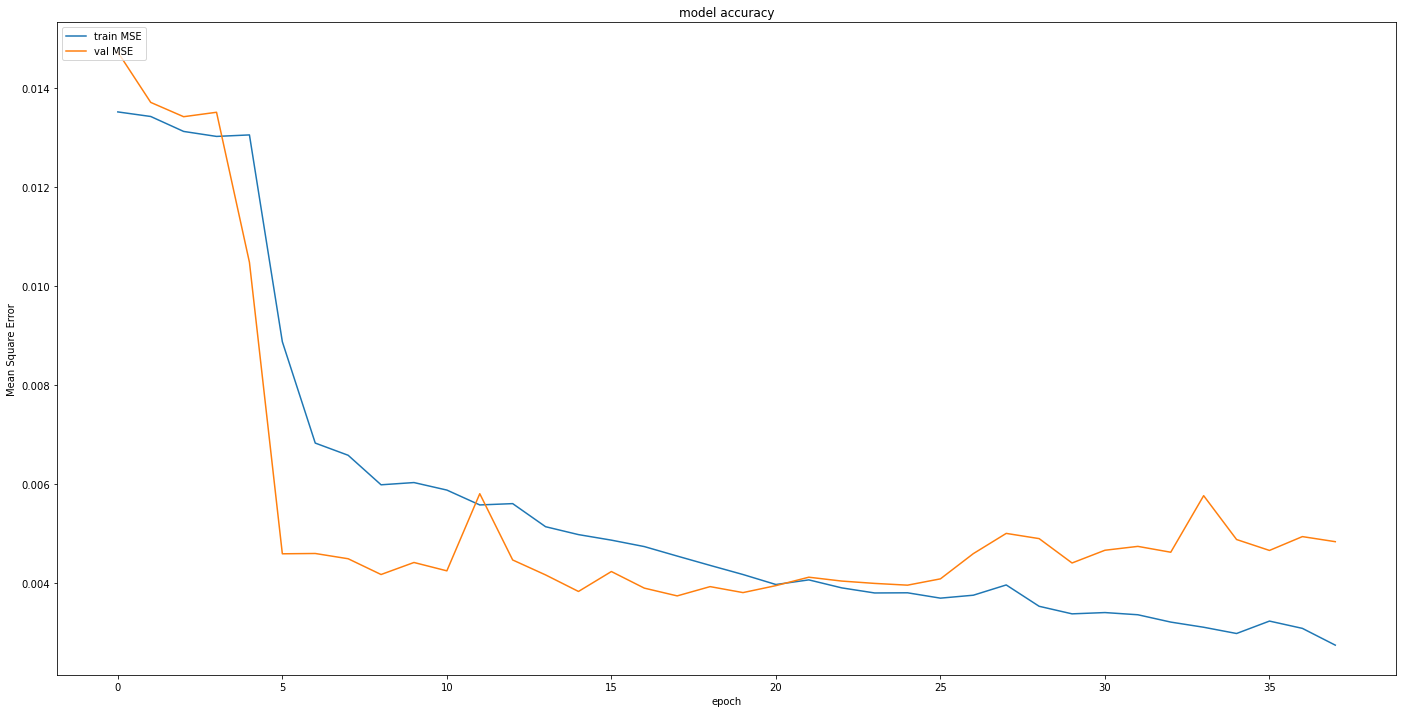

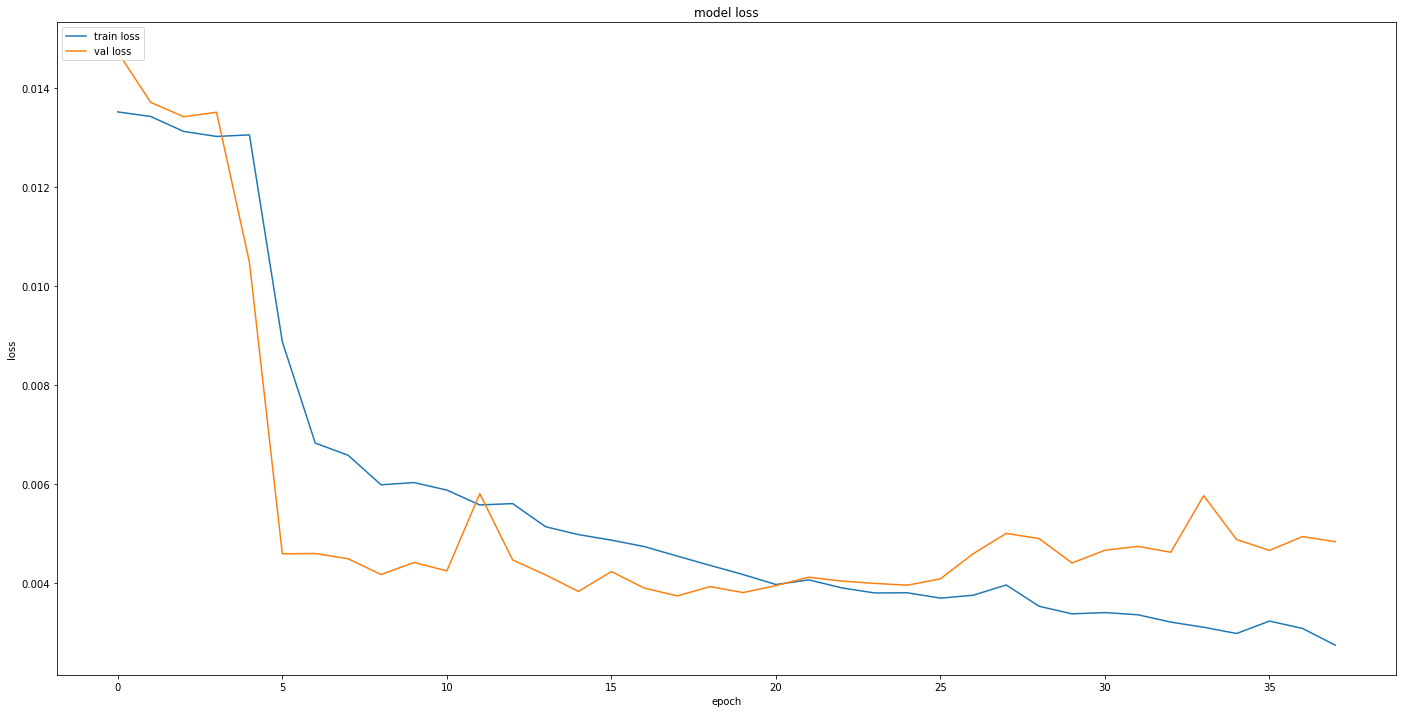

In [39]:
# plot Mean absolute error
loss_plot(History)

In [40]:
nan_count = np.sum(np.isnan(x_train))
print(f"There are {nan_count} NaN values in x_train.")

There are 0 NaN values in x_train.


In [41]:
nan_count = np.sum(np.isnan(x_test))
print(f"There are {nan_count} NaN values in x_test.")

There are 0 NaN values in x_test.


7/7 [==============================] - 1s 7ms/step
Mean Square Error: 20.66
Mean Absolute Error: 1.39
Root Mean Square Error: 4.55
R-Square: -649691.52




<AxesSubplot:xlabel='SampleTimeUTC'>

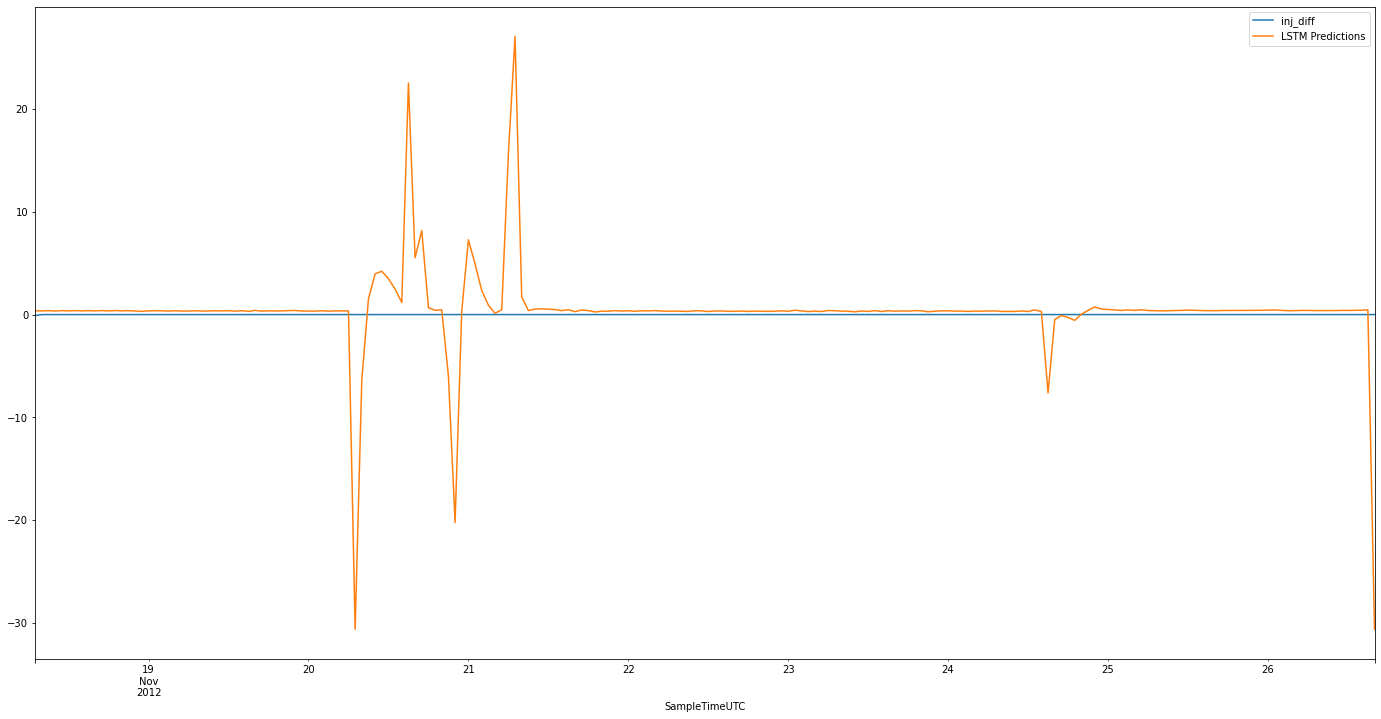

In [42]:
# make predictions and transform
test_pred = scaler.inverse_transform(model.predict(x_test))

pred_test = test2[(n_steps_in-1):].copy()
pred_test["LSTM Predictions"] = test_pred
pred_test = pred_test[["inj_diff", "LSTM Predictions"]]

# evaluate predictions accuracy
evaluate_prediction(pred_test["LSTM Predictions"], pred_test["inj_diff"])

pred_test.plot()

In [43]:
pred_test

,inj_diff,LSTM Predictions
SampleTimeUTC,,
2012-11-18 07:00:00,-0.080345,0.366370
2012-11-18 08:00:00,0.000000,0.355850
2012-11-18 09:00:00,0.000000,0.383941
2012-11-18 10:00:00,0.000000,0.344349
2012-11-18 11:00:00,0.000000,0.387078
...,...,...
2012-11-26 12:00:00,0.000000,0.402854
2012-11-26 13:00:00,0.000000,0.412900
2012-11-26 14:00:00,0.000000,0.421484


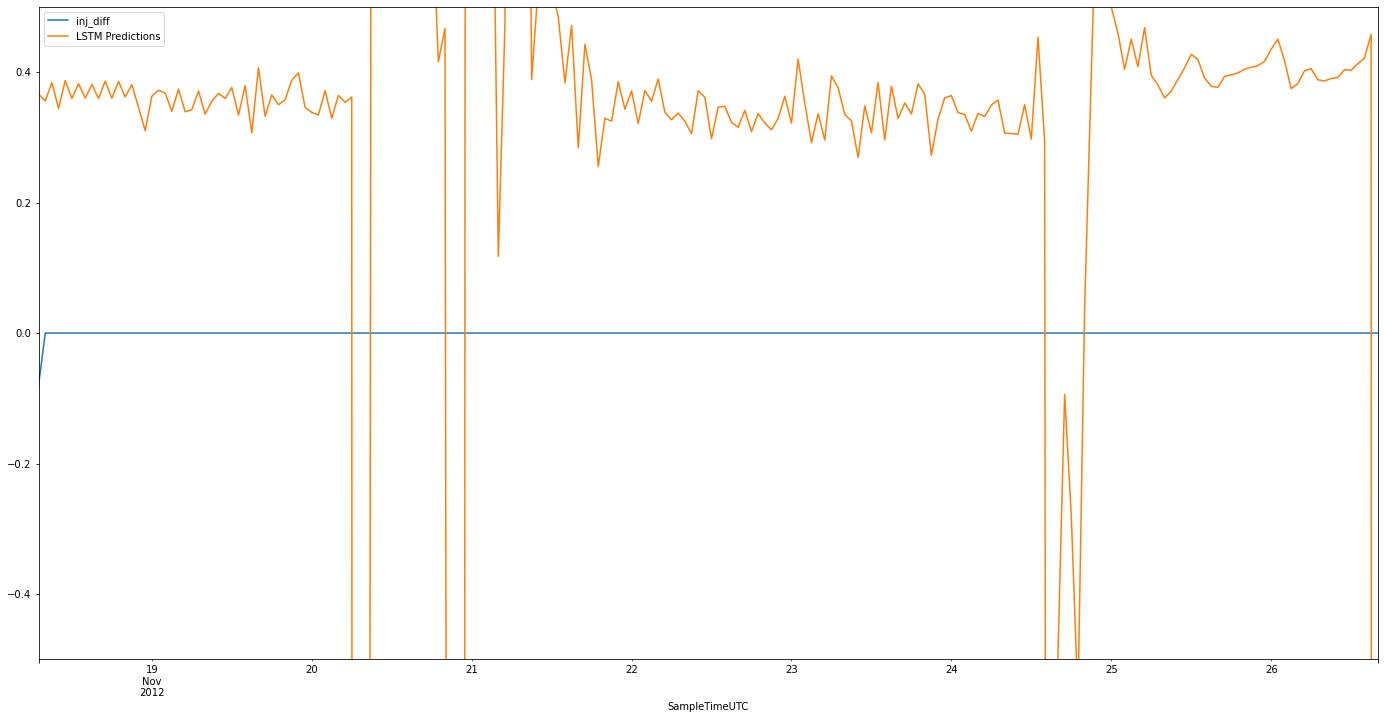

In [44]:
pred_test.plot()
# Set the y-axis limit
plt.ylim([-0.5, 0.5])
#plt.xlim(['2012-08-01', '2012-08-31'])

# Display the plot
plt.show()

In [45]:
# save dataframe to CSV file
pred_test.to_csv("output.csv", index=False)